In [1]:
import pandas as pd
import numpy as np
import nltk
from pprint import pprint

from nltk.corpus import stopwords
# if this is first time you use nltk, please open terminal and type codes bellow 
#   >>> import nltk
#   >>> nltk.download('stopwords')
#   >>> nltk.download('punkt')

stops = set(stopwords.words('english'))
import string
puns = string.punctuation

# Word2Vec
1. 簡介
    
    Word2Vec其實是Word to Vector的簡稱，意在將每一個字轉換成一條向量，並讓這字的語意透過這條向量描繪出來。早期做自然語言處理時，很難對讓電腦對詞背後的意思有更深一層的理解，因此詞與詞之間的關係很難被挖掘出來，像是相似詞、相反詞、對應詞等，因此Word2Vec在這樣的背景下產生就顯得極其珍貴。
    
    
2. 作用&賣點
    1. 它可以找到相似的字。
    2. 它可以加減，像是Taiwan-Taipei=Germany-Berlin。
    
3. 訓練方法: 參照[這篇網誌](https://goatwang.github.io/2017/06/06/Train-Wiki-Corpus-by-gensim-Word2vec/)

4. 已經訓練好的model:
    1. [Various Models](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/)
    2. 本課程使用之[GloVe Word2Vec](https://nlp.stanford.edu/projects/glove/)(時間考量已經壓縮過，只留下這個文件中會用到的字)。

5. 專案: 將e-commerce商品標籤分群

# Load Data

In [2]:
with open('all_categories.list', 'r', encoding='utf8') as f:
    all_categories = np.array(eval(f.read()))
print("商品標籤個數:", len(all_categories))
print("前10個商品標籤:", all_categories[:10])


商品標籤個數: 910
前10個商品標籤: ['Small Animal' 'Kitchen' 'Fragrance' 'Track & Sweat Suits' 'Wallet'
 'Favors' 'Quilts' 'Sticker' 'Pets' 'Skirt']


In [3]:
word_vec_mapping = {}
path = "glove.twitter.27B.50d.txt"

# 打開上述檔案，並將每一行中的第一個詞作為key，後面的數字做為向量，加入到word_vec_mapping
with open(path, 'r', encoding='utf8') as f:  ## 這個文檔的格式是一行一個字並配上他的向量，以空白鍵分隔
    for line in f:  
        #=============your works starts===============#
        tokens = line.split()
        token = tokens[0]  ## 第一個token就是詞彙
        vec = tokens[1:]  ## 後面的token向量
        word_vec_mapping[token] = np.array(vec, dtype=np.float32)  ## 把整個model做成一個字典，以利查找字對應的向量
        #==============your works ends================#

vec_dimensions = len(word_vec_mapping.get('men'))
print("vec_dimensions:", vec_dimensions)
print("word_vec_mapping length:", len(list(word_vec_mapping.items())))
pprint(list(word_vec_mapping.items())[:5])
# vec_dimensions: 50
# word_vec_mapping length: 947
# [('shoes',
#   array([-0.75313002, -1.78719997,  0.14522   , -0.29681   ,  0.12436   ,
#        -0.40922999,  1.22679996,  0.50806999,  0.27913001,  0.34277001,
#        -0.013902  ,  1.52499998, -3.44880009,  1.05630004, -0.49985   ,

vec_dimensions: 50
word_vec_mapping length: 947
[('protection',
  array([-2.6041e-01,  9.3470e-03, -1.2779e+00,  9.3997e-01,  1.3464e-01,
        2.8652e-01,  4.7567e-01, -5.1847e-01,  6.8337e-01, -6.8621e-01,
        2.5913e-01,  2.9725e-01, -2.7242e+00,  3.8473e-01,  1.2560e+00,
        9.2542e-01, -1.0193e-01,  1.5966e-01,  2.2935e-03, -3.8759e-01,
       -1.0683e+00, -5.3661e-01,  6.1156e-03,  1.5376e-01,  3.5490e-01,
        5.9846e-01,  8.5329e-02,  8.7829e-01,  2.1870e-01,  1.0114e+00,
       -6.9214e-03, -5.1215e-01, -2.7296e-01, -8.3198e-01,  8.5664e-01,
       -5.2144e-01, -4.6561e-01,  9.8429e-01, -6.7122e-01, -9.6129e-01,
        7.8881e-01, -6.1323e-01,  2.6551e-01, -3.9457e-01,  5.8291e-01,
       -5.6443e-01,  3.0565e-01,  4.1577e-02,  8.3677e-01, -4.5295e-01],
      dtype=float32)),
 ('headsets',
  array([-0.026823 , -0.092859 , -1.0312   ,  0.90884  , -0.49068  ,
        0.3701   ,  0.63185  , -0.61496  ,  0.57759  , -1.0434   ,
       -0.21304  ,  1.0892   , -0.67756 

# Tokenize & Doc2Vec

In [4]:
# 將每一個句子(商品類別)的詞彙
# 1. 切割開來
# 2. 去掉停用字stops
# 3. 去掉標點符號(string.punctuation)
# 4. 轉小寫

def tokenize(Doc):
    if pd.notnull(Doc):
        # 使用nltk.wordpunct_tokenize將Doc切開
        # 去掉停用字與標點符號，並轉小寫
        #=============your works starts===============#
        tokens = nltk.wordpunct_tokenize(Doc)
        words = [w.lower() for w in tokens if w not in stops and w not in puns]
        #==============your works ends================#
        return words
    else:
        return None
    
print("before tokenize:", all_categories[0])
print("after tokenize:", tokenize(all_categories[0]))
print("before tokenize:", all_categories[3])
print("after tokenize:", tokenize(all_categories[3]))
# before tokenize: Small Animal
# after tokenize: ['small', 'animal']
# before tokenize: Track & Sweat Suits
# after tokenize: ['track', 'sweat', 'suits']

before tokenize: Small Animal
after tokenize: ['small', 'animal']
before tokenize: Track & Sweat Suits
after tokenize: ['track', 'sweat', 'suits']


In [5]:
test_arr = np.array([
    [1,2,3,4],
    [4,5,6,7],
    [7,8,9,10]
])
# 請將test_arr中的三個array做element-wise的平均
#=============your works starts===============#
test_out = np.average(test_arr, axis=0)
#==============your works ends================#

print(test_out)
# [4. 5. 6. 7.]

[4. 5. 6. 7.]


In [6]:
def doc2vec(doc, word2vec=word_vec_mapping):
    if pd.notnull(doc):
        # 使用剛剛定義好的tokenize函式tokenize doc，並指派到terms
        # 找出每一個詞彙的代表向量(word_vec_mapping)
        # 並平均(element-wise)所有出現的詞彙向量(注意axis=0)，作為doc的代表向量
        #=============your works starts===============#
        terms = tokenize(doc)  ## 把類別tokenize成一個個的詞彙
        termvecs = [word_vec_mapping.get(term) for term in terms if term in word_vec_mapping.keys()]
        docvec = np.average(np.array(termvecs), axis=0)
        #==============your works ends================#
    
    if np.sum(np.isnan(docvec)) > 0:
        ## 若找不到對應的詞向量，則給一條全部為零的向量，長度為原詞彙代表向量的長度(vec_dimensions)
        #=============your works starts===============#
        docvec=np.zeros(vec_dimensions, )  ## 先初始化一條向量，如果某個類別裡面的字都沒有在字典裡，那麼會回傳這條向量
        #==============your works ends================#
    return docvec

print("before tokenize:", all_categories[3])
print("output shape", doc2vec(all_categories[3]).shape)
print("after tokenize:", doc2vec(all_categories[3])[:5])
print("before tokenize:", all_categories[70])
print("output shape", doc2vec(all_categories[70]).shape)
print("after tokenize:", doc2vec(all_categories[70])[:5])
# before tokenize: Track & Sweat Suits
# output shape (50,)
# after tokenize: [-0.76383996 -0.49650002  0.23154134 -0.16717     0.42855397]
# before tokenize: Teethers
# output shape (50,)
# after tokenize: [0. 0. 0. 0. 0.]

before tokenize: Track & Sweat Suits
output shape (50,)
after tokenize: [-0.76383996 -0.49650002  0.23154134 -0.16717     0.42855397]
before tokenize: Teethers
output shape (50,)
after tokenize: [0. 0. 0. 0. 0.]


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
# 將doc2vec應用到all_categories中的每一個元素上
#=============your works starts===============#
cat_vecs = np.array(list(map(doc2vec, all_categories)))
#==============your works ends================#

print("cat_vecs length:", len(cat_vecs))
print(cat_vecs[3][:5])
print(cat_vecs.shape)
# cat_vecs length: 910
# [-0.76383996 -0.49650002  0.23154134 -0.16717     0.42855397]
# (910, 50)

cat_vecs length: 910
[-0.76383996 -0.49650002  0.23154134 -0.16717     0.42855397]
(910, 50)


# Clustering

In [8]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from collections import Counter
X = cat_vecs
n_clusters= 20

## K means

In [9]:
# 請使用kmeans將商品類別分成20類
#=============your works starts===============#
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
all_categories_labels_kmeans = kmeans.fit_predict(X)
#==============your works ends================#

for i in range(3):
    print(";;".join(all_categories[all_categories_labels_kmeans==i]))
    print("=============")

Athletic Training;;Golf;;Golf Apparel;;Track & Field;;Boxing & MMA;;Lacrosse;;Hockey;;Badminton;;Bowl;;Golf Balls;;Varsity;;Team Sports;;Athletic;;Volleyball;;MLB;;Gear;;NBA;;Games;;Game;;Basket;;Football;;Bowling;;Pitcher;;Tennis & Racquets;;Cup;;Outdoor Games;;Baseball & Softball;;Baseball;;Sports Bras;;Sports & Outdoor Play;;Sport;;Indoor;;Athletic Apparel;;Sports & Outdoors;;Sports;;Women's Golf Clubs;;Soccer;;NHL;;Fantasy;;NFL;;NCAA;;Basketball;;Men's Golf Clubs;;Polo, Rugby
Small Animal;;Pets;;Animals;;Toddler;;Animal;;Art Doll;;Kids;;Human Figure Doll;;Afghan;;Doll Clothing;;Women;;Women's Accessories;;Finding;;Pet Lover;;Bags & Cases;;Toys;;Electronics for Kids;;Children's Books;;Kids' Bath;;Other Accessories;;Children;;Baby & Toddler Toys;;Stuffed Animals & Plush;;Costume;;Child Friendly;;Women's Handbags;;Doll;;Kids' Bedding;;Doll Clothes;;Feeding;;Pet Supplies;;Dogs
Girls;;Face;;Fan Shop;;Dress Up & Pretend Play;;Sleep Positioners;;Watch;;Boys;;50 To 75 Years;;Desktops & All

## Hireachy(single link)

In [10]:
# 請使用hierachical(single link)將商品類別分成20類
#=============your works starts===============#
hierachy = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
all_categories_labels_single = hierachy.fit_predict(X)
#==============your works ends================#


for i in range(3):
    print(";;".join(all_categories[all_categories_labels_single==i]))
    print("=============")

Athletic Training;;Motorcycle;;Golf;;Golf Apparel;;Hiking & Camping;;Water Sports;;Bike & Skate;;Track & Field;;Boxing & MMA;;Coaster;;Badminton;;Golf Balls;;Cargo;;Tweezers;;Bass Guitars;;Outdoor;;Brass Instruments;;Athletic;;Yoga & Pilates;;Polo;;Gear;;Training Pants;;Motorcycle & Powersports;;Swim Trunks;;Basket;;Stringed Instruments;;Bowling;;Casual Shorts;;Guitars;;Tennis & Racquets;;Outdoors;;Band & Orchestra;;Fishing;;Cup;;Outdoor Games;;Swim Briefs;;Maxi;;Leash;;Sports & Outdoor Play;;Instrument;;Skateboard;;Golf Bags;;Indoor;;Musical instruments;;Athletic Apparel;;Ballet;;Sports & Outdoors;;Women's Golf Clubs;;Snowboard;;Formal;;Wind & Woodwind Instruments;;Board Shorts;;Men's Golf Clubs;;Casual Pants;;Board, Surf;;Drums & Percussion;;Poncho;;Coasters;;Golf Shoes;;Polo, Rugby
Historical, Military;;Exercise;;Arts & Crafts;;Education & Teaching;;Writing;;Potty Training;;Afghan;;Presentation;;Learning & Education;;Religion;;Sports Nutrition;;Peasant;;Politics & Social Sciences;;P

## Hireachy(average link)

In [11]:
# 請使用hierachical(average link)將商品類別分成20類
#=============your works starts===============#
hierachy = AgglomerativeClustering(linkage='average', n_clusters=n_clusters)
all_categories_labels_average = hierachy.fit_predict(X)
#==============your works ends================#


for i in range(3):
    print(";;".join(all_categories[all_categories_labels_average==i]))
    print("=============")

Athletic Training;;Boxing & MMA;;Lacrosse;;Hockey;;Badminton;;Bowl;;Varsity;;Team Sports;;Athletic;;Volleyball;;MLB;;NBA;;Games;;Game;;Basket;;Football;;Bowling;;Pitcher;;Tennis & Racquets;;Cup;;Baseball & Softball;;Fans;;Baseball;;Sports;;Soccer;;Bowls;;NHL;;Fixture;;NFL;;NCAA;;Basketball
Dusting;;Waxing;;Thermometers;;Oils & Fluids;;Toothbrushes;;Sponges;;Brushes & Applicators;;Brushes;;Conditioners;;Mopping;;Televisions;;Cables & Adapters;;Nasal Aspirators;;Batteries;;Binoculars & Telescopes;;Magnets;;Soaps & Cleansers;;Cleansers;;Microwaves;;Headsets;;Shampoos;;Sweeping;;Refrigerators;;Powders & Lotions;;Computers & Tablets;;Gadgets;;Laptops & Netbooks;;Keyboards;;Washers & Dryers;;Vests
Eyes;;Feet;;Sleep Positioners;;Lips;;Relaxed


## Hireachy(complete link)

In [12]:
# 請使用hierachical(complete link)將商品類別分成20類
#=============your works starts===============#
hierachy = AgglomerativeClustering(linkage='complete', n_clusters=n_clusters)
all_categories_labels_complete = hierachy.fit_predict(X)
#==============your works ends================#


for i in range(3):
    print(";;".join(all_categories[all_categories_labels_complete==i]))
    print("=============")

Kitchen;;Photo Albums & Frames;;Plush;;Storage & Organization;;Knitting Supplies;;Puzzles;;Baskets & Bins;;Yarn;;Baguette;;Paintings;;Crafting;;Storage & Containers;;Garage Storage & Organization;;Home Decor;;Knitting;;Kitchen Storage & Organization;;Outdoor;;Bouquets;;Frame;;Dolls and Miniatures;;Ceramic;;Nursery;;Carving;;Cleaning;;Kids' Furniture;;Puzzle;;Maternity Pillows;;Blankets & Throws;;Sculptures;;Other Furniture;;Patterns;;Dishes;;Washcloths & Towels;;Ornaments;;Photographs;;Peasant;;Home Office Furniture;;Bathroom Storage & Organization;;Kitchen & Table Linens;;Origami;;Hobbies;;Bedroom Furniture;;Antique;;Scale Dollhouse Miniature;;Storage Cabinets;;Mattress Pads;;Home Bar Furniture;;Bath Rugs;;Figurine;;Pillows & Stools;;Artwork;;Crochet;;Decorating;;Teacup;;Pillow;;Sewing;;Planter;;Table;;Pillows;;Baskets;;Indoor;;Figurines;;Cleaning Supplies;;Fabric;;Comforters & Sets;;Laundry Storage & Organization;;Stuffed Animals & Plush;;Collages;;Hawaiian;;Drawings;;Furniture;;Bath

## DBSCAN

In [13]:
# 請使用hierachical(complete link)將商品類別分成20類(eps=0.3)
#=============your works starts===============#
dbscan = DBSCAN(eps=0.3)
all_categories_labels_dbscan = dbscan.fit_predict(X)
#==============your works ends================#

for i in [-1, 0]:
    print(";;".join(all_categories[all_categories_labels_dbscan==i]))
    print("=============")

Small Animal;;Kitchen;;Fragrance;;Track & Sweat Suits;;Wallet;;Favors;;Quilts;;Sticker;;Pets;;Skirt;;Crewneck;;Athletic Training;;Luggage;;Plate;;Full-Length;;Coffee & Tea Accessories;;Turtleneck;;Eyes;;Dresses;;Motorcycle;;Dusting;;Animals;;Pot Holder;;Calendars;;Shams, Bed Skirts & Bed Frame Draperies;;Photo Albums & Frames;;Diapering;;Plush;;Storage & Organization;;Golf;;Golf Apparel;;Leggings;;Medical Supplies & Equipment;;Books;;Girls;;Historical, Military;;Waxing;;Straight, Pencil;;Men's Accessories;;Knitting Supplies;;Puzzles;;Hair Relaxers;;Vest;;Nail Care;;Hiking & Camping;;Water Sports;;Bike & Skate;;Gloves;;Changing Kits;;Monitors;;Car Electronics & Accessories;;Sweatshirt, Pullover;;Trading Cards;;TV, Audio & Surveillance;;Jeans;;Charm;;Weddings;;GPS Accessories & Mounts;;Toddler;;Pouch;;Exercise;;Pregnancy & Maternity;;Beads;;Face;;Track & Field;;Bubble Bath;;Studio Recording Equipment;;Boxing & MMA;;Feet;;Baskets & Bins;;Lacrosse;;Animal;;Fan Shop;;Fashion Sneakers;;V-Nec

In [14]:
all_categories_labels_dbscam = DBSCAN().fit_predict(X)
Counter(all_categories_labels_dbscam)
# Counter({-1: 898, 0: 12})

Counter({-1: 898, 0: 12})

In [15]:
df_cat = pd.DataFrame(all_categories_labels_dbscam, index=all_categories, columns=['label'])
print(list(df_cat[df_cat['label'] == 0].index))
# ['Teethers', 'Playards', 'Epilators', 'Sweatercoat', 'Rainwear', 'Needlecraft', 'Bedspreads & Coverlets', 'Dehumidifiers', 'Humidifiers', 'Paperweights', 'Papermaking', 'other']

['Teethers', 'Playards', 'Epilators', 'Sweatercoat', 'Rainwear', 'Needlecraft', 'Bedspreads & Coverlets', 'Dehumidifiers', 'Humidifiers', 'Paperweights', 'Papermaking', 'other']


# PCA

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def draw_PCA(X, Y, title):
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)

    X_reduced = PCA(n_components=3).fit_transform(X)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title(title)
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

    plt.show()

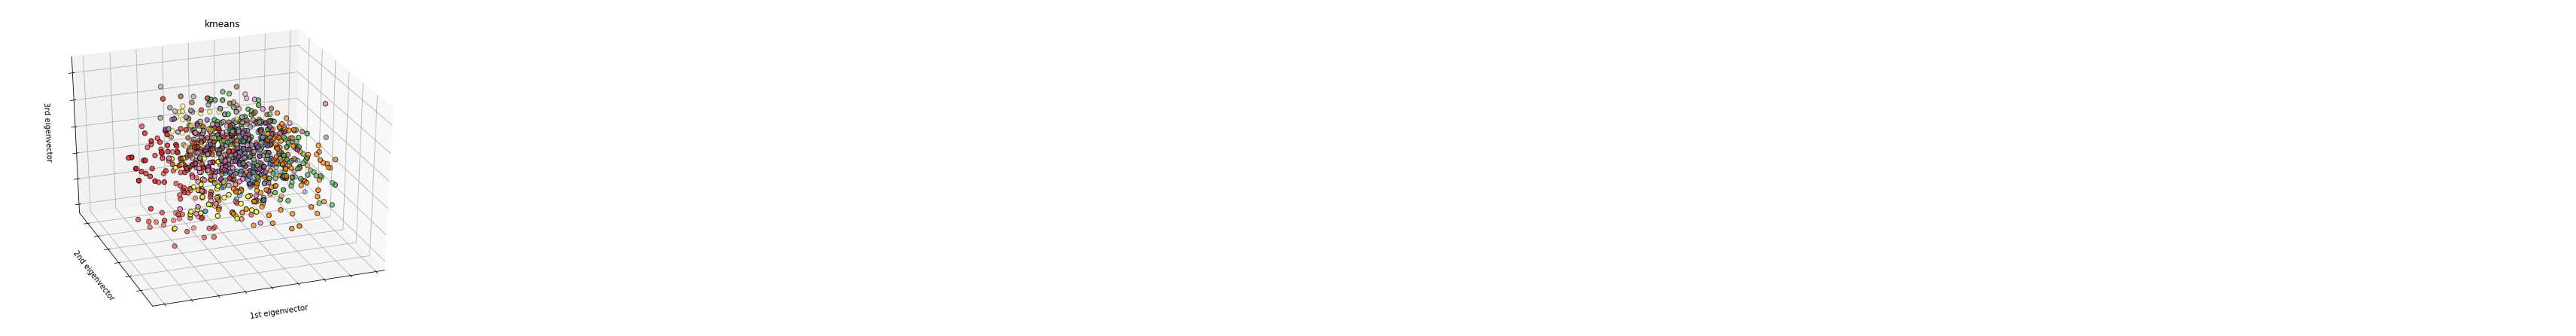

In [17]:
draw_PCA(X, all_categories_labels_kmeans, 'kmeans')

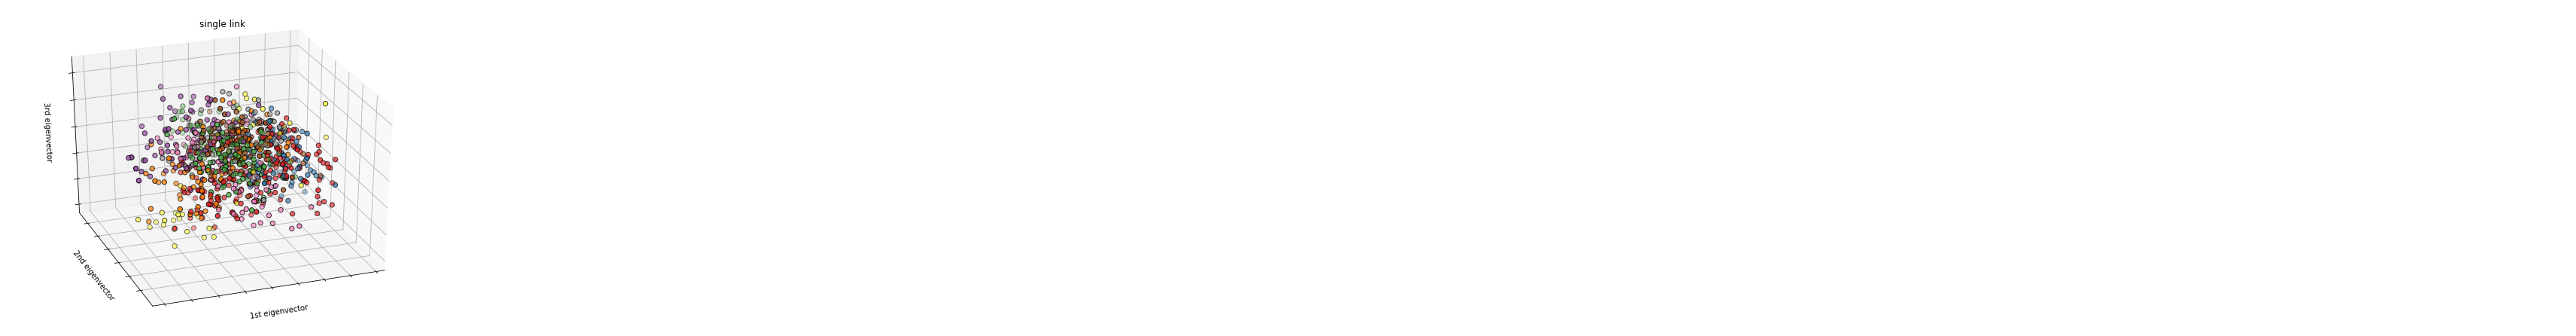

In [18]:
draw_PCA(X, all_categories_labels_single, 'single link')

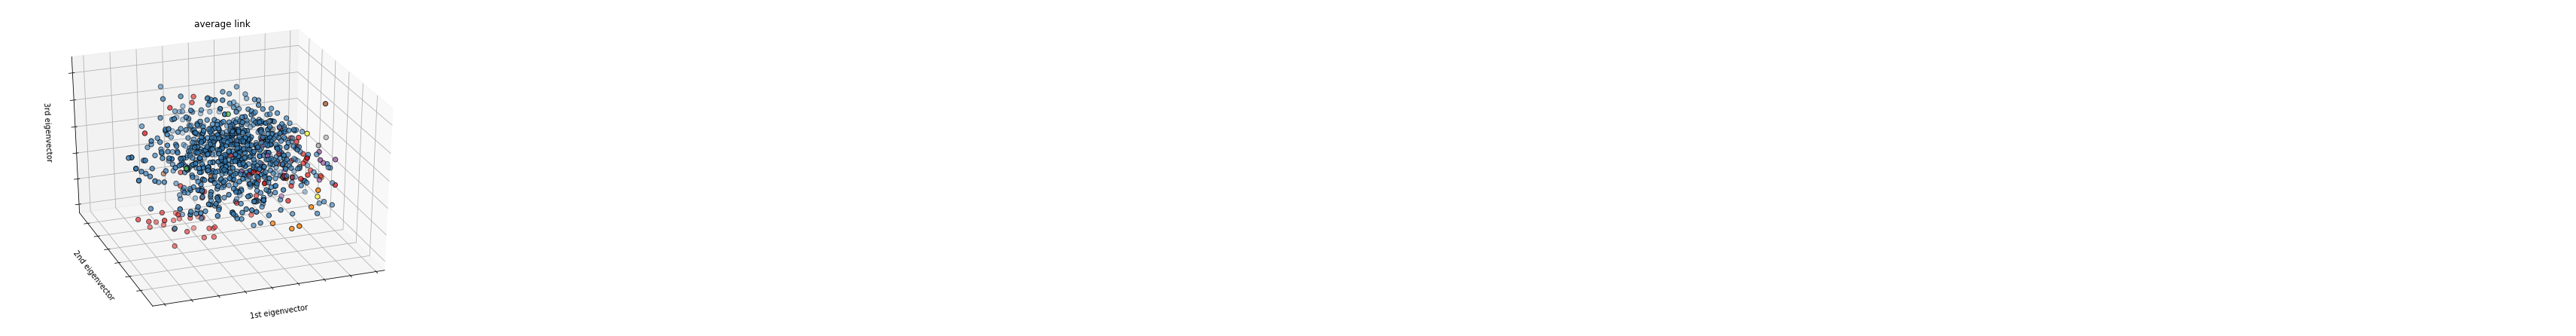

In [19]:
draw_PCA(X, all_categories_labels_average, 'average link')

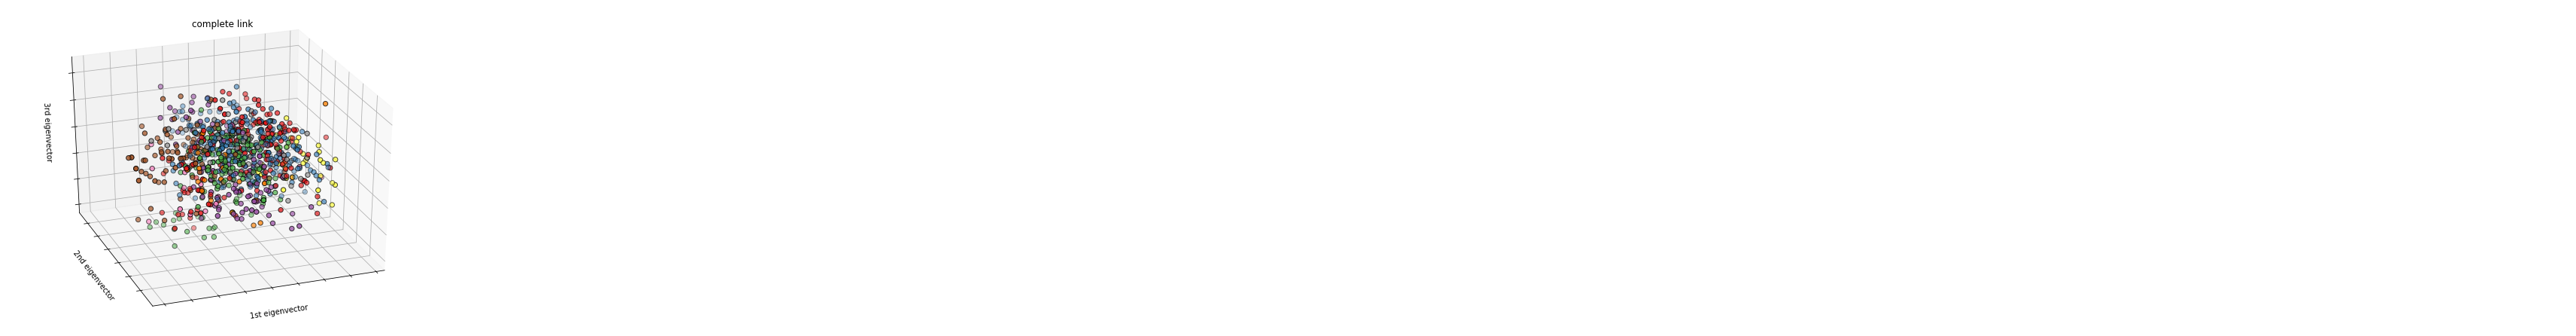

In [20]:
draw_PCA(X, all_categories_labels_complete, 'complete link')

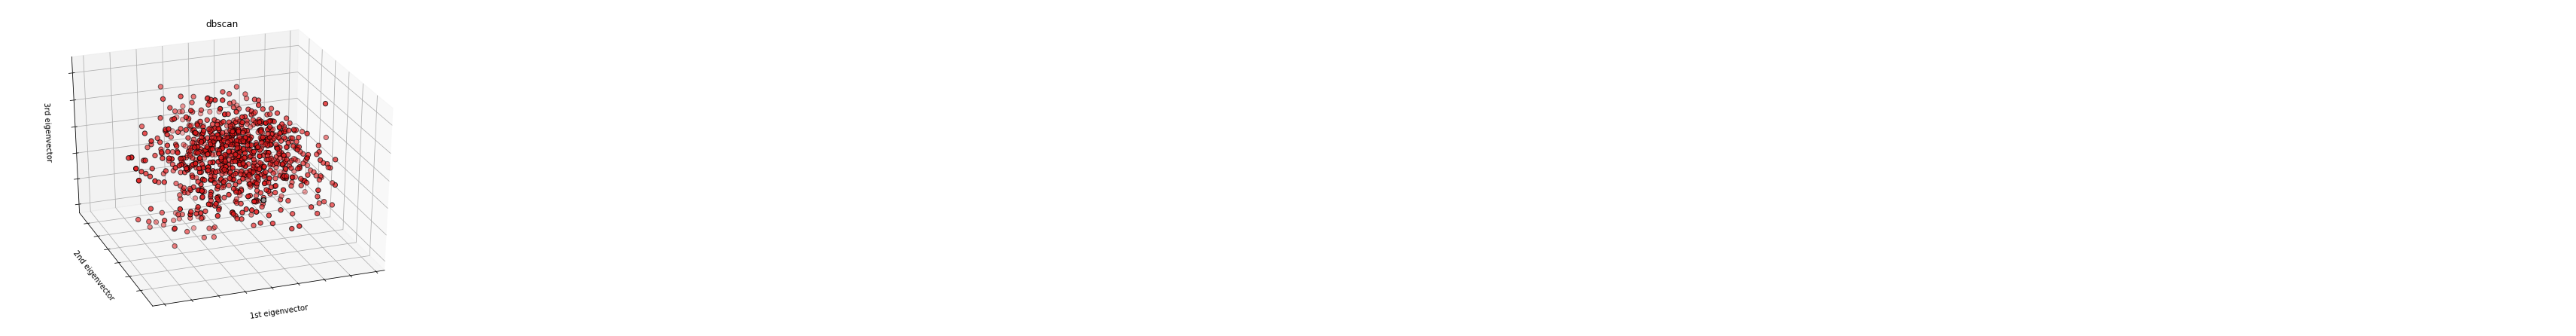

In [21]:
draw_PCA(X, all_categories_labels_dbscan, 'dbscan')

# Evaluation

In [22]:
df_cat = pd.DataFrame(all_categories_labels_kmeans, index=all_categories, columns=['label'])
for i in range(len(set(all_categories_labels_kmeans))):
    cats = list(df_cat[df_cat['label'] == i].index)    
    print("cluster " + str(i) + ": ")
    print(list(cats))
    print("=============================================")
    print("=============================================")


cluster 0: 
['Athletic Training', 'Golf', 'Golf Apparel', 'Track & Field', 'Boxing & MMA', 'Lacrosse', 'Hockey', 'Badminton', 'Bowl', 'Golf Balls', 'Varsity', 'Team Sports', 'Athletic', 'Volleyball', 'MLB', 'Gear', 'NBA', 'Games', 'Game', 'Basket', 'Football', 'Bowling', 'Pitcher', 'Tennis & Racquets', 'Cup', 'Outdoor Games', 'Baseball & Softball', 'Baseball', 'Sports Bras', 'Sports & Outdoor Play', 'Sport', 'Indoor', 'Athletic Apparel', 'Sports & Outdoors', 'Sports', "Women's Golf Clubs", 'Soccer', 'NHL', 'Fantasy', 'NFL', 'NCAA', 'Basketball', "Men's Golf Clubs", 'Polo, Rugby']
cluster 1: 
['Small Animal', 'Pets', 'Animals', 'Toddler', 'Animal', 'Art Doll', 'Kids', 'Human Figure Doll', 'Afghan', 'Doll Clothing', 'Women', "Women's Accessories", 'Finding', 'Pet Lover', 'Bags & Cases', 'Toys', 'Electronics for Kids', "Children's Books", "Kids' Bath", 'Other Accessories', 'Children', 'Baby & Toddler Toys', 'Stuffed Animals & Plush', 'Costume', 'Child Friendly', "Women's Handbags", 'Doll'

In [23]:
df_cat = pd.DataFrame(all_categories_labels_single, index=all_categories, columns=['label'])
for i in range(len(set(all_categories_labels_kmeans))):
    cats = list(df_cat[df_cat['label'] == i].index)    
    print("cluster " + str(i) + ": ")
    print(sorted(list(cats)))
    print("=============================================")
    print("=============================================")

cluster 0: 
['Athletic', 'Athletic Apparel', 'Athletic Training', 'Badminton', 'Ballet', 'Band & Orchestra', 'Basket', 'Bass Guitars', 'Bike & Skate', 'Board Shorts', 'Board, Surf', 'Bowling', 'Boxing & MMA', 'Brass Instruments', 'Cargo', 'Casual Pants', 'Casual Shorts', 'Coaster', 'Coasters', 'Cup', 'Drums & Percussion', 'Fishing', 'Formal', 'Gear', 'Golf', 'Golf Apparel', 'Golf Bags', 'Golf Balls', 'Golf Shoes', 'Guitars', 'Hiking & Camping', 'Indoor', 'Instrument', 'Leash', 'Maxi', "Men's Golf Clubs", 'Motorcycle', 'Motorcycle & Powersports', 'Musical instruments', 'Outdoor', 'Outdoor Games', 'Outdoors', 'Polo', 'Polo, Rugby', 'Poncho', 'Skateboard', 'Snowboard', 'Sports & Outdoor Play', 'Sports & Outdoors', 'Stringed Instruments', 'Swim Briefs', 'Swim Trunks', 'Tennis & Racquets', 'Track & Field', 'Training Pants', 'Tweezers', 'Water Sports', 'Wind & Woodwind Instruments', "Women's Golf Clubs", 'Yoga & Pilates']
cluster 1: 
['Afghan', 'Arts & Crafts', 'Bomber', 'Education & Teachin